<a href="https://colab.research.google.com/github/Mudit1234Sinha/Sentiment-Analysis/blob/main/Sentiment_Analysis_using_GloVe_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
# Download data from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

!wget --quiet "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
!unzip -q "sentiment labelled sentences"
!mv "sentiment labelled sentences" data
!ls -l data

total 208
-rw-r--r-- 1 root root 58226 Jul  5  2016 amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Feb 15  2015 imdb_labelled.txt
-rw-r--r-- 1 root root  1070 May 31  2015 readme.txt
-rw-r--r-- 1 root root 61320 Jul  5  2016 yelp_labelled.txt


In [ ]:
files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

trainingData = pd.concat(df_list)

print('Number of rows: %d' % len(trainingData))

trainingData.head(10)

Number of rows: 2748


,comment,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


In [ ]:
# Download GloVe embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!echo "Unzipping glove.6B.zip"
!unzip -q glove.6B.zip
!echo "All done!"

--2021-11-01 14:54:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-01 14:54:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-01 14:54:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 50

num_classes = 2

def load_glove_vectors():
    print('Loading glove vectors...')
    glove_map = {}
    with open('glove.6B.%dd.txt' % EMBEDDING_DIM, encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            glove_map[word] = np.asarray(values[1:], dtype='float32')
    return glove_map

def create_embedding_matrix(word_index, num_words):
    glove_map = load_glove_vectors()
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > num_words:
            continue
        vector = glove_map.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

In [ ]:
comments = trainingData.comment.astype(str).tolist()
sentiments = trainingData.sentiment.tolist()
labels = np.asarray(sentiments)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

num_words = min(MAX_NB_WORDS, len(word_index)) + 1

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

In [ ]:
embedding_matrix = create_embedding_matrix(word_index, num_words)

Loading glove vectors...


In [ ]:
dropout = 0.4

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(dropout))

model.add(Conv1D(128, 5, activation='relu', padding='same', strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          263600    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 128)          32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

Epoch 1/40
18/18 [==============================] - 6s 275ms/step - loss: 0.8449 - acc: 0.5141 - val_loss: 0.6712 - val_acc: 0.5909
Epoch 2/40
18/18 [==============================] - 5s 269ms/step - loss: 0.7116 - acc: 0.5614 - val_loss: 0.6639 - val_acc: 0.6218
Epoch 3/40
18/18 [==============================] - 5s 267ms/step - loss: 0.6831 - acc: 0.5837 - val_loss: 0.6587 - val_acc: 0.5964
Epoch 4/40
18/18 [==============================] - 5s 267ms/step - loss: 0.6761 - acc: 0.5942 - val_loss: 0.6414 - val_acc: 0.6764
Epoch 5/40
18/18 [==============================] - 5s 268ms/step - loss: 0.6535 - acc: 0.6178 - val_loss: 0.6255 - val_acc: 0.6855
Epoch 6/40
18/18 [==============================] - 5s 266ms/step - loss: 0.6251 - acc: 0.6465 - val_loss: 0.6130 - val_acc: 0.6618
Epoch 7/40
18/18 [==============================] - 5s 271ms/step - loss: 0.6115 - acc: 0.6588 - val_loss: 0.5925 - val_acc: 0.7055
Epoch 8/40
18/18 [==============================] - 5s 267ms/step - loss: 0.

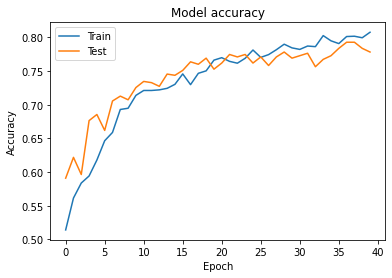

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

# Train model for a given number of epochs
history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

# Evaluate model against test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(padded_sequences)
most_likely = predictions.argmax(1)

In [ ]:
index = random.randrange(len(predictions))
print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

That was done in the second movie.  
Prediction: 0, label: 0


I still maintain that monkeys shouldn't make headphones, we just obviously don't share enough DNA to copy the design over to humans.
Prediction: 1, label: 0


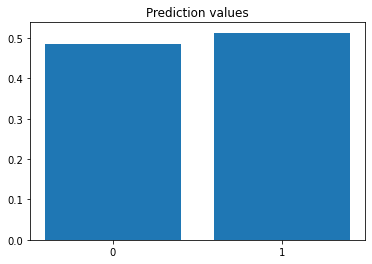

In [ ]:
for i in range(10000):
    index = random.randrange(len(predictions))
    if most_likely[index] != sentiments[index]:
        break

print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

plt.bar(range(num_classes), predictions[index], tick_label=range(num_classes))
plt.title('Prediction values')
plt.show()